# Fine-Tuning of Language Models with QLoRA

In this notebook we will continue to work with PyTorch and Open AI's early Open Source Model GPT2 to develop a deeper understanding and intuition of how language models are fine-tuned with parameter efficient fine tuning (PEFT) techniques. We will continue to look at a specific simple task, Sentiment Classification, and see how we can fine tune two different models to improve performance.

1. **Fine-tuning of [GPT2 large](https://huggingface.co/openai-community/gpt2-large) with a sentiment classification dataset**  

   Here we will explore how we can combine Low Rank Adaptation (LoRA) with Quantization to fine tune a larger model.  We'll leverage the libaries from [Hugging Face](https://huggingface.co/docs/transformers/index) to use their AutoModel and AutoTokenizer classes as well as their Trainer class to fine tune a model to do sentiment classification. We'll experiment with some of the hyperparameters that affect LoRA performance to see what makes a positive or negative contribution.
   We will learn that the Huggingface infrastructure allows us to easily fine tune much larger models than we could normally fit on our compute resources.

2. **Fine-tuning of Gemma model for Sentiment Analysis**  
   We will then use a larger more recent model -- [Gemma 2](https://huggingface.co/google/gemma-2b) from Google -- to illustrate the benefits of an increase in the number of parameters and how it affects the performance of the model.  This model doubles the number or parameters but has also undergone a better pre-training regime and we would expect that to be reflected in the performance of the model.



In [ ]:
%%capture

!pip install datasets==2.21.0
!pip install transformers
!pip install accelerate -U            # Quantization, Distribution
!pip install -q peft                  # LoRA
!pip install -q evaluate
!pip install bitsandbytes             # QLoRA

In [ ]:
import sys
import numpy as np
import torch

import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import BitsAndBytesConfig

from datasets import load_dataset, load_metric

from peft import LoraConfig, TaskType, PeftModel, get_peft_model
from peft import load_peft_weights, set_peft_model_state_dict
from peft import PromptEncoderConfig, prepare_model_for_kbit_training

import datasets
import random
import pandas as pd
from IPython.display import display, HTML

import wandb
wandb.init(mode="disabled")

In [ ]:
def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))


def preprocess_function(examples):
    if sentence2_key is None:
        return tokenizer(examples[sentence1_key], truncation=True)
    return tokenizer(examples[sentence1_key], examples[sentence2_key], truncation=True)


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

def show_currently_allocated_gpu_mem():
  torch.cuda.empty_cache()
  mem = torch.cuda.memory_allocated()
  print(f"Current GPU memory allocation (GB): {mem/1024**3}")

## 1. Data Setup

We use the [GLUE dataset](https://gluebenchmark.com/), one of the original NLP "benchmarks", loading the data for the Stanford Sentiment Treebank task. We will also define the tokenizer for our first model (they all use the GPT2 tokenizer).

In [ ]:
task = actual_task = "sst2"

base_model_name = "gpt2-large"  # GPT2

batch_size = 16

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(base_model_name, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
dataset = load_dataset("glue", actual_task, trust_remote_code=True)
metric = load_metric('glue', actual_task, trust_remote_code=True)

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

<ipython-input-6-2142620635>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('glue', actual_task, trust_remote_code=True)


To access an actual record, you need to select a split first, then give an index:

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})

Let's look at one record in the train split they provide.

In [ ]:
dataset["train"][2]

{'sentence': 'that loves its characters and communicates something rather beautiful about human nature ',
 'label': 1,
 'idx': 2}

**QUESTION:**

1.a. How many records in the train split of the sst dataset we're using?

In [ ]:
### Q1-a Grading Tag: Please put your answer in this cell. Don't edit this line.

### YOUR ANSWER HERE
"67349"
### END YOUR ANSWER

'67349'

**QUESTION:**

1.b. How many records are in the test split of the sst dataset we're using?

In [ ]:
### Q1-b Grading Tag: Please put your answer in this cell. Don't edit this line.

### YOUR ANSWER HERE
"1821"
### END YOUR ANSWER

'1821'

To get a sense of what the data looks like, the following function will show some examples picked randomly in the dataset.

In [ ]:
show_random_elements(dataset["train"])

,sentence,label,idx
0,"it 's mildly interesting to ponder the peculiar american style of justice that plays out here ,",positive,64392
1,in a sincere performance,positive,30369
2,'s black hawk down with more heart,positive,16238
3,"ramsay succeeds primarily with her typical blend of unsettling atmospherics , delivering a series of abrasive , stylized sequences that burn themselves upon the viewer 's memory .",positive,34172
4,sketchy characters and immature provocations can fully succeed at cheapening it .,negative,4442
5,beginning with the pale script,negative,15294
6,"this woefully hackneyed movie , directed by scott kalvert , about street gangs and turf wars in 1958 brooklyn -- stale cliches , gratuitous violence , or empty machismo",negative,61338
7,has the rare capability to soothe and break your heart with a single stroke,positive,63853
8,the script by vincent r. nebrida ... tries to cram too many ingredients into one small pot .,negative,22567
9,priceless,positive,65260


You can call the `compute` method associated with the glue benchmark, pass your predictions and labels directly and it will return a dictionary with the metric(s) value:

In [ ]:
fake_preds = np.random.randint(0, 2, size=(64,))
fake_labels = np.random.randint(0, 2, size=(64,))
metric.compute(predictions=fake_preds, references=fake_labels)

{'accuracy': 0.53125}

In [ ]:
sentence1_key, sentence2_key = ("sentence", None)

We need to take the text input and run it through the tokenizer to get input_ids, following (https://github.com/huggingface/notebooks/blob/main/examples/text_classification.ipynb).  We construct a properly formatted input for the Trainer class using the pre-process function defined above.

In [ ]:
encoded_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

Lastly, we define for the future analysis the base model, the metric, and the key for the validation data in the encoded dataset:

In [ ]:
metric_name = "accuracy"

validation_key = "validation"

##2. QLoRA Setup

Now let's use QLoRA to fine-tune a model that is quantized down to a much smaller bit representation. We first need to specify the BitsAndBytes configuration, then the LoRA adapter, and then we'll train as always. But now we will use the [large model](https://huggingface.co/openai-community/gpt2-large) with 812 million parameters. That would **not** fit into our T4 chip for training purposes. It will work with QLoRA! How good will the results be?  Let find out.

First, your need to fill in the values of the BitsAndBytesConfig.

In [ ]:
bnb_config = BitsAndBytesConfig(
    ### YOUR CODE HERE
    load_in_4bit=True,  # Enable 4-bit quantization
    bnb_4bit_quant_type="nf4", # Set quantization type to "nf4"
    bnb_4bit_compute_dtype=torch.bfloat16, # Set compute dtype to bfloat16
    bnb_4bit_use_double_quant=False, # Disable double quantization

    ### END YOUR CODE
)

**QUESTION:**

1.c. What is our quantization goal - 16 bit, 8 bit or 4 bit?

In [ ]:
### Q1-c Grading Tag: Please put your answer in this cell. Don't edit this line.

### YOUR ANSWER HERE
"QLoRA uses 4-bit quantization"
### END YOUR ANSWER

'QLoRA uses 4-bit quantization'

Let's take advantage of Hugging Face's AutoModel classes.  We're doing classification so we're going to want the AutoModelForSequenceClassification class. They've already attached an output layer for us so we simply need to load the model weights and we can fine tune our classifier.

In [ ]:
qlora_model = AutoModelForSequenceClassification.from_pretrained(base_model_name, quantization_config=bnb_config, device_map={"":0})

qlora_model.config.pad_token_id = qlora_model.config.eos_token_id

model.safetensors:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2-large and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We can see the components of the model below. It tells us how the underlying decoder is structured.  You can see linear layer they've attached.  I generates two outputs -- one will be for positive e.g. 1 in the label and a second for negative e.g. 0 in the label.

In [ ]:
print(qlora_model)

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1280)
    (wpe): Embedding(1024, 1280)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-35): 36 x GPT2Block(
        (ln_1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Linear4bit(in_features=1280, out_features=3840, bias=True)
          (c_proj): Linear4bit(in_features=1280, out_features=1280, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Linear4bit(in_features=1280, out_features=5120, bias=True)
          (c_proj): Linear4bit(in_features=5120, out_features=1280, bias=True)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1280,), eps=

**QUESTION:**

1.d. What kind of activation function is used in the MLP portion of the model?  RELU, LRELU, SPELU, or GELU?

In [ ]:
### Q1-d Grading Tag: Please put your answer in this cell. Don't edit this line.

### YOUR ANSWER HERE
"New GELU"
### END YOUR ANSWER

'New GELU'

Looking at the contents of model.config can also be very helpful.

In [ ]:
print(qlora_model.config)

GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 1280,
  "n_head": 20,
  "n_inner": null,
  "n_layer": 36,
  "n_positions": 1024,
  "pad_token_id": 50256,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "bfloat16",
    "bnb_4bit_quant_storage": "uint8",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": false,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_modules": null,
    "llm_int8_threshold": 6.0,
    "load_in_4bit": true,
    "load_in_8bit": false,
    "quant_method": "bitsandbytes"
  },
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scal

Now let's see how much of the GPU memory is consumed by the model BEFORE we add in the adapter.

In [ ]:
show_currently_allocated_gpu_mem()

Current GPU memory allocation (GB): 0.5561223030090332


We need to do a few more adjustments:

In [ ]:
qlora_model.gradient_checkpointing_enable()
qlora_model = prepare_model_for_kbit_training(qlora_model)


Now, very importantly, we need to set the size of our adapter.  Specifically we need to set the value of the rank and the alpha.  You can read about the purpose of these values in [this excellent blog](https://www.determined.ai/blog/lora-parameters) about fine-tuning with LoRA.

In [ ]:
config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS"
)

qlora_model = get_peft_model(qlora_model, config)
qlora_model.print_trainable_parameters()

trainable params: 1,477,120 || all params: 775,509,760 || trainable%: 0.1905


In [ ]:
qlora_model(**tokenizer('this is fun', return_tensors='pt').to('cuda'))['logits']

tensor([[1.3354, 0.1054]], device='cuda:0', grad_fn=<IndexBackward0>)

Now, let's see how much memory the LoRA adapter is using.  By looking at the difference between the GPU memory allocation before and after we can see how much space the adapter is using.

In [ ]:
show_currently_allocated_gpu_mem()

Current GPU memory allocation (GB): 0.7051472663879395


Now we need to configure the Hugging Face Trainer.  This involves filling out the Training Arguments structure so we can pass it on the to Trainer class when we instntiate it.  As indicated in the blog you need to find a good learning rate that will allow you to get an evaluation accuracy above 0.92.  You can experiment with multiple values.  Once you find a good one you can shift to finding good r and alpha values.

In [ ]:
## Training Arguments structure
args = TrainingArguments(
    f"qlora_{base_model_name}-finetuned-{task}",
    eval_strategy = "steps",
    eval_steps = 100,
    save_strategy = "no",
    logging_strategy = "steps",
    logging_steps = 100,
    learning_rate=3e-4,                   ### YOUR EXPERIMENT VALUE HERE!
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=1,
    max_steps=300,
    weight_decay=0.01,
    load_best_model_at_end=False,
    metric_for_best_model=metric_name,
)


## Trainer we'll use to fine tune
qlora_trainer = Trainer(
    qlora_model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset[validation_key],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)



<ipython-input-57-363341050>:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  qlora_trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Now that we have configured the trainer we can easily train the model by simply calling trainer.train()



In [ ]:
qlora_trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss,Validation Loss,Accuracy
100,0.229300,0.292036,0.922018
200,0.189700,0.258546,0.923165
300,0.211800,0.227724,0.926606


TrainOutput(global_step=300, training_loss=0.21027297337849934, metrics={'train_runtime': 360.3445, 'train_samples_per_second': 13.321, 'train_steps_per_second': 0.833, 'total_flos': 684337472962560.0, 'train_loss': 0.21027297337849934, 'epoch': 0.07125890736342043})

Let's evaluate the trainer against our validation test set and see how well our model is performing.  The trainer class simplifies the evaluation process as well.  Your goal is to get an 'eval_accuracy' above 0.92 by manipulating the values for r, lora alpha, and the learning rate.

In [ ]:
qlora_trainer.evaluate()

{'eval_loss': 0.2277236133813858,
 'eval_accuracy': 0.926605504587156,
 'eval_runtime': 22.7366,
 'eval_samples_per_second': 38.352,
 'eval_steps_per_second': 2.419,
 'epoch': 0.07125890736342043}

**QUESTION:**

1.e. What is the value of the learning rate that allows you to get an evaluation accuracy above 0.92?

In [ ]:
### Q1-e Grading Tag: Please put your answer in this cell. Don't edit this line.

### YOUR ANSWER HERE
"3e-4"
### END YOUR ANSWER

'3e-4'

**QUESTION:**

1.f. What is the r value of your LoRA adapter that lets you get an evaluation accuracy above 0.92?

In [ ]:
### Q1-f Grading Tag: Please put your answer in this cell. Don't edit this line.

### YOUR ANSWER HERE
"8"
### END YOUR ANSWER

'8'

**QUESTION:**

1.g. What is the r-alpha value of your LoRA adapter that lets you get an evaluation accuracy above 0.92?

In [ ]:
### Q1-g Grading Tag: Please put your answer in this cell. Don't edit this line.

### YOUR ANSWER HERE
"16"
### END YOUR ANSWER

'16'

Be very careful using this as it will clean out memory.  Only use it once you've identified the values you're happy with in fine-tuning GPT2 and you're ready to move on to the next model.

In [ ]:
del qlora_trainer

## 3. Larger Model Data Setup

Now let's try running the same data through a more recent model, specifically Gemma2 from Google.  You can check out [the model card](https://huggingface.co/google/gemma-2-2b) -- always a good idea or the [Technical Report](https://arxiv.org/pdf/2408.00118). We again need to define the tokenizer for our second model so we can reprocess the data.

In order to use this model you will need to identify yourself to HuggingFace. If you don't already have an account with Hugging Face, you should get one.  You can then log in to the Hugging Face site and from there go to [the model card](https://huggingface.co/google/gemma-2-2b) and request access to the Gemma model.  Once you are granted access -- usually a matter of minutes -- you will see something like the following when you visit the model card:

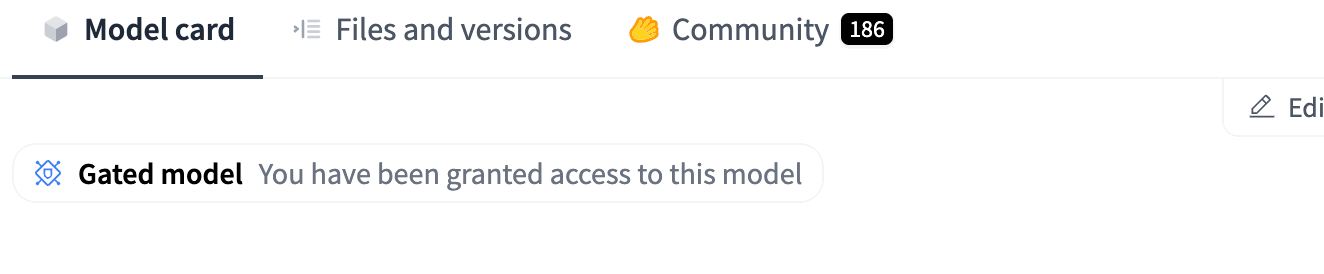

In [ ]:
task = actual_task = "sst2"
large_model_name = "google/gemma-2-2b"
batch_size = 16

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(large_model_name, use_fast=True,)
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

We're using a new model and it has its own tokenizer so we need to reprocess the data with that new tokenizer.

In [ ]:
encoded_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

Lastly, we define for the future analysis the metric and the key for the validation data in the encoded dataset:

In [ ]:
metric_name = "accuracy"

validation_key = "validation"

##4. Larger QLoRA Setup

Now let's use QLoRA to fine-tune a model that is quantized down to a much smaller number of bits. We first need to specify the BitsAndBytes configuration, then the LoRA adapter, and then we'll train. But now we will use a very recent LLM [and larger model](https://huggingface.co/google/gemma-2-2b) with 2.61 billion parameters. That would **not** fit into our T4 chip for training purposes. It will work with QLoRA. And how good it be relative to the GPT2 model we fine-tuned first?

First you need to fill in the BitsAndBytesConfig file again.

In [ ]:
bnb_config = BitsAndBytesConfig(
    ### YOUR CODE HERE
    load_in_4bit=True,  # Enable 4-bit quantization
    bnb_4bit_quant_type="nf4", # Set quantization type to "nf4"
    bnb_4bit_compute_dtype=torch.bfloat16, # Set compute dtype to bfloat16
    bnb_4bit_use_double_quant=False, # Disable double quantization

    ### END YOUR CODE
)

Let's take advantage of Hugging Face's AutoModel classes.  We're doing classification so again we'll use the AutoModelForSequenceClassification. They've already attached an output layer for us so we simply need to load the model weights.

In [ ]:
lqlora_model = AutoModelForSequenceClassification.from_pretrained(large_model_name, quantization_config=bnb_config, device_map={"":0})

lqlora_model.config.pad_token_id = lqlora_model.config.eos_token_id

config.json:   0%|          | 0.00/818 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/481M [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some weights of Gemma2ForSequenceClassification were not initialized from the model checkpoint at google/gemma-2-2b and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We can see the components of the model below. It tells us how the underlying decoder is structured.  You can see

In [ ]:
print(lqlora_model)

Gemma2ForSequenceClassification(
  (model): Gemma2Model(
    (embed_tokens): Embedding(256000, 2304, padding_idx=0)
    (layers): ModuleList(
      (0-25): 26 x Gemma2DecoderLayer(
        (self_attn): Gemma2Attention(
          (q_proj): Linear4bit(in_features=2304, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2304, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=2304, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2304, bias=False)
        )
        (mlp): Gemma2MLP(
          (gate_proj): Linear4bit(in_features=2304, out_features=9216, bias=False)
          (up_proj): Linear4bit(in_features=2304, out_features=9216, bias=False)
          (down_proj): Linear4bit(in_features=9216, out_features=2304, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (post_attention_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)

Looking t the contents of model.config can also be very helpful.

In [ ]:
print(lqlora_model.config)

Gemma2Config {
  "architectures": [
    "Gemma2ForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "attn_logit_softcapping": 50.0,
  "bos_token_id": 2,
  "cache_implementation": "hybrid",
  "eos_token_id": 1,
  "final_logit_softcapping": 30.0,
  "head_dim": 256,
  "hidden_act": "gelu_pytorch_tanh",
  "hidden_activation": "gelu_pytorch_tanh",
  "hidden_size": 2304,
  "initializer_range": 0.02,
  "intermediate_size": 9216,
  "max_position_embeddings": 8192,
  "model_type": "gemma2",
  "num_attention_heads": 8,
  "num_hidden_layers": 26,
  "num_key_value_heads": 4,
  "pad_token_id": 1,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "bfloat16",
    "bnb_4bit_quant_storage": "uint8",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": false,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_modules": null,
    "llm_int8_threshold": 6.0

Now that we've loaded the Gemma model into memory let's see what size footprint it has.

In [ ]:
show_currently_allocated_gpu_mem()

Current GPU memory allocation (GB): 2.8957371711730957


We need to do a few more adjustments to take advantge of the model:

In [ ]:
lqlora_model.gradient_checkpointing_enable()
lqlora_model = prepare_model_for_kbit_training(lqlora_model)


Now you can experiment a bit with the values for r, lora_alpha, and the learning rate.  For staters try using the values you landed upon when you were fine-tuning GPT2-large.

In [ ]:
lconfig = LoraConfig(
    r=8,             ###### YOUR VALUE HERE
    lora_alpha=16,    ###### YOUR VALUE HERE
    lora_dropout=0.1,  ###### YOUR VALUE HERE
    bias="none",
    task_type="SEQ_CLS"
)

lqlora_model = get_peft_model(lqlora_model, lconfig)
lqlora_model.print_trainable_parameters()

trainable params: 1,602,048 || all params: 2,615,948,544 || trainable%: 0.0612


**QUESTION:**

1.h. What is the r value of your LoRA adapter that lets you get an evaluation accuracy above 0.95?

In [ ]:
### Q1-h Grading Tag: Please put your answer in this cell. Don't edit this line.

### YOUR ANSWER HERE
"8"
### END YOUR ANSWER

'8'

**QUESTION:**

1.i. What is the r-alpha value of your LoRA adapter that lets you get an evaluation accuracy above 0.95?

In [ ]:
### Q1-i Grading Tag: Please put your answer in this cell. Don't edit this line.

### YOUR ANSWER HERE
"16"
### END YOUR ANSWER

In [ ]:
#qlora_model.to('cuda')
lqlora_model(**tokenizer('this is fun', return_tensors='pt').to('cuda'))['logits']

tensor([[ 2.2843, -1.9544]], device='cuda:0', grad_fn=<IndexBackward0>)

**QUESTION:**

1.j. What is the number of trainable parameters in the QLoRA model for Gemma-2-2B?

In [ ]:
### Q1-j Grading Tag: Please put your answer in this cell. Don't edit this line.

### YOUR ANSWER HERE
"1,602,048"
### END YOUR ANSWER

'1,602,048'

In [ ]:
show_currently_allocated_gpu_mem()

Current GPU memory allocation (GB): 4.021071434020996


In [ ]:
largs = TrainingArguments(
    f"lqlora_{large_model_name}-finetuned-{task}",
    eval_strategy = "steps",
    eval_steps = 100,
    save_strategy = "no",
    logging_strategy = "steps",
    logging_steps = 100,
    learning_rate=2e-4,                ####### YOUR VALUE HERE
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=1,
    max_steps=300,
    weight_decay=0.01,
    load_best_model_at_end=False,
    metric_for_best_model=metric_name,
    #push_to_hub=True,
)

lqlora_trainer = Trainer(
    lqlora_model,
    largs,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset[validation_key],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)



<ipython-input-91-265334330>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  lqlora_trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


**QUESTION:**

1.k. What is the learning rate you are using for the larger QLoRA model to get a validation accuracy above 0.95?

In [ ]:
### Q1-k Grading Tag: Please put your answer in this cell. Don't edit this line.

### YOUR ANSWER HERE
"2e-4"
### END YOUR ANSWER

Now that we have configured the trainer we can easily train the model by simply calling trainer.train()



In [ ]:
lqlora_trainer.train()

A ConfigError was raised whilst setting the number of model parameters in Weights & Biases config.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss,Validation Loss,Model Preparation Time,Accuracy
100,0.208800,0.210559,0.005400,0.951835
200,0.153500,0.257361,0.005400,0.951835
300,0.191900,0.222087,0.005400,0.961009


TrainOutput(global_step=300, training_loss=0.18474268595377605, metrics={'train_runtime': 907.0113, 'train_samples_per_second': 5.292, 'train_steps_per_second': 0.331, 'total_flos': 1940216863334400.0, 'train_loss': 0.18474268595377605, 'epoch': 0.07125890736342043})

Let's evaluate the trainer against our validation test set and see how well our model is performing.  The trainer class simplifies the evaluation process as well.

In [ ]:
lqlora_trainer.evaluate()

{'eval_loss': 0.22208695113658905,
 'eval_model_preparation_time': 0.0054,
 'eval_accuracy': 0.9610091743119266,
 'eval_runtime': 54.1135,
 'eval_samples_per_second': 16.114,
 'eval_steps_per_second': 1.016,
 'epoch': 0.07125890736342043}

**QUESTION:**

1.l. What is the final evaluation accuracy you get on the larger model?
 (Must be above 0.95)

In [ ]:
### Q1-l Grading Tag: Please put your answer in this cell. Don't edit this line.

### YOUR ANSWER HERE
"0.9610091743119266"
### END YOUR ANSWER

'0.9610091743119266'

Okay, youre done with assignment III.  Hopefully you've had a gentle introduction to using quantization and LoRA to fine tune different decoder based models.